In [1]:
# 1. Imports & Paths
import importlib.util
import os, sys, re, pandas as pd
sys.path.append(os.path.join(os.pardir, "utils"))

DATA_DIR = os.path.join(os.pardir, "data")
resume_path = os.path.join(DATA_DIR, "resumes_cleaned.csv")
jobs_path   = os.path.join(DATA_DIR, "jobs_cleaned.csv")

In [2]:
# 2. Load Data
resume_df = pd.read_csv(resume_path)
job_posts_df = pd.read_csv(jobs_path)

In [3]:
%load_ext autoreload
%autoreload 2
from utils import *


c:\Users\adity\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


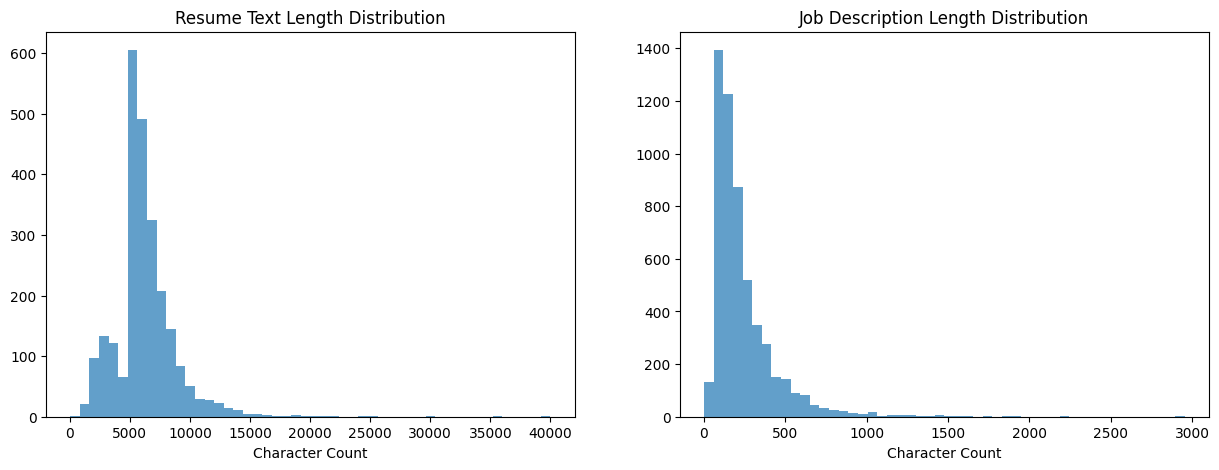

In [4]:
resume_lengths = resume_df['Resume_str'].str.len()
job_lengths = job_posts_df['JobDescription'].str.len()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(resume_lengths, bins=50, alpha=0.7)
ax1.set_title('Resume Text Length Distribution')
ax1.set_xlabel('Character Count')

ax2.hist(job_lengths, bins=50, alpha=0.7)
ax2.set_title('Job Description Length Distribution')
ax2.set_xlabel('Character Count')
plt.show()

[('state', 15935), ('city', 14977), ('company', 14161), ('name', 11658), ('management', 8016), ('customer', 7455), ('business', 7163), ('sales', 6366), ('new', 6292), ('skills', 5865), ('team', 5207), ('experience', 5018), ('project', 4720), ('service', 4528), ('training', 4488), ('work', 4305), ('development', 4039), ('information', 3844), ('education', 3768), ('financial', 3765), ('including', 3745), ('professional', 3640), ('manager', 3636), ('marketing', 3411), ('data', 3364), ('support', 3303), ('managed', 3279), ('university', 3188), ('staff', 3079), ('developed', 2996), ('management,', 2960), ('office', 2855), ('microsoft', 2726), ('current', 2714), ('process', 2706), ('product', 2696), ('responsible', 2675), ('maintained', 2616), ('system', 2594), ('quality', 2529), ('ensure', 2458), ('design', 2436), ('high', 2414), ('customers', 2346), ('client', 2331)]
[('looking', 1720), ('responsible', 1660), ('position', 1313), ('development', 1283), ('incumbent', 1279), ('seeking', 1236)

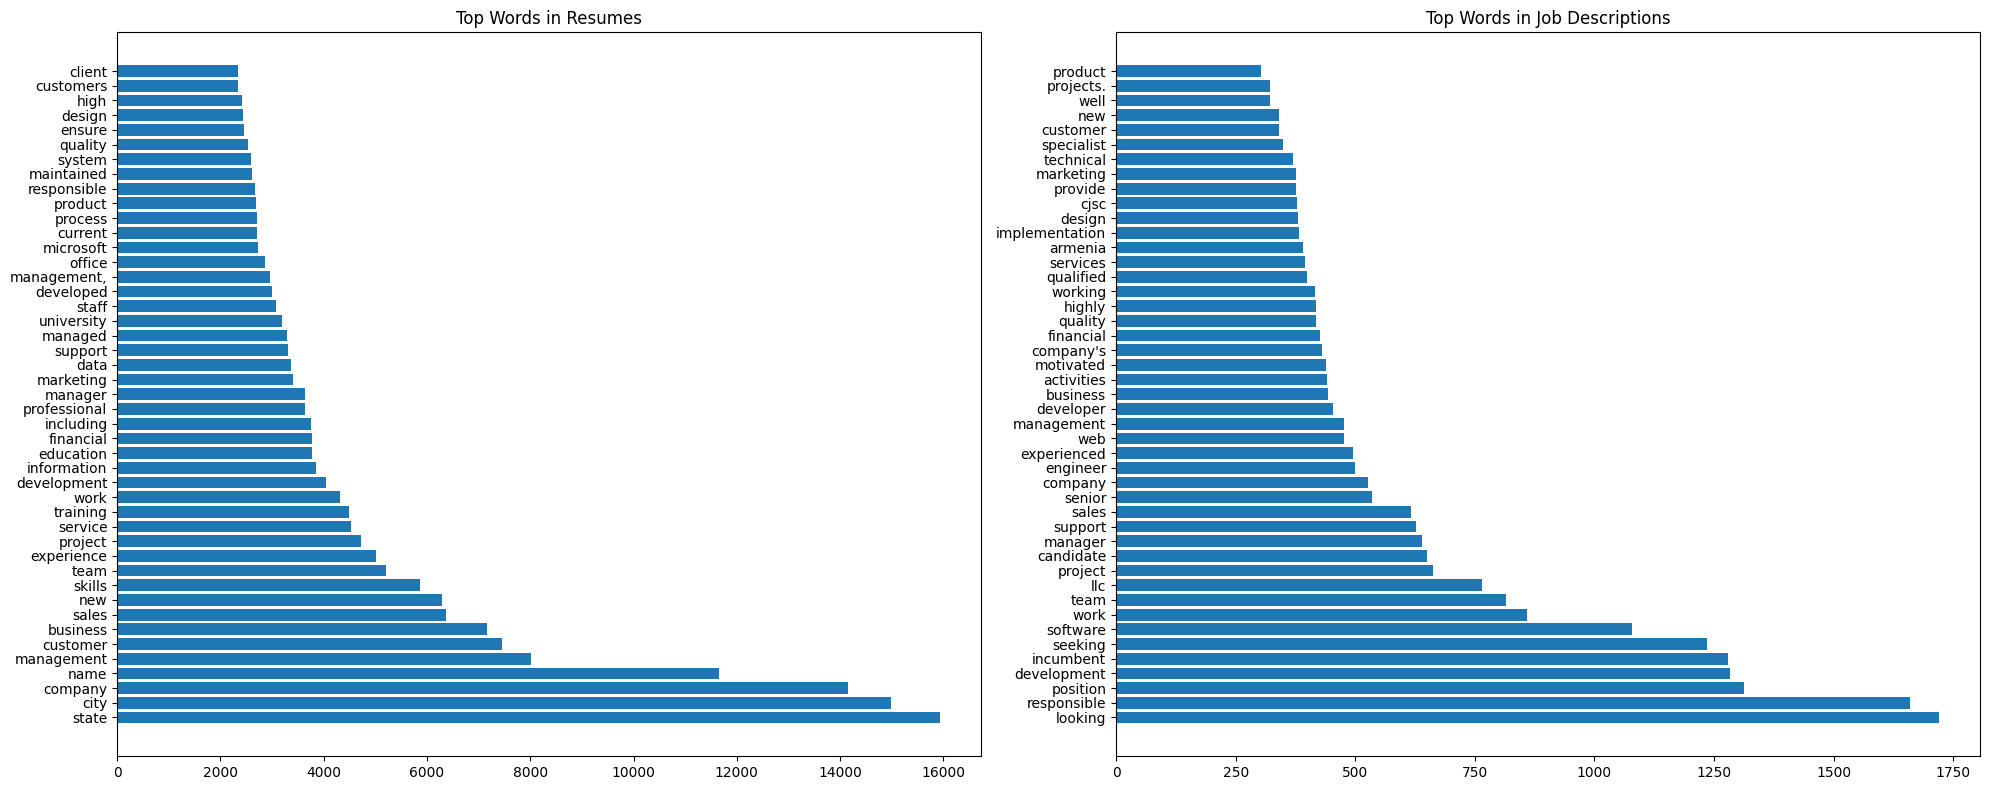

In [5]:
# Get most common words in resumes and job postings
def get_top_words(text_series, n=45):
    all_words = ' '.join(text_series).lower().split()
    # Remove stopwords and short words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in all_words if word not in stop_words and len(word) > 2]
    return Counter(filtered_words).most_common(n)

top_resume_words = get_top_words(resume_df['Resume_str'])
top_job_words = get_top_words(job_posts_df['JobDescription'])
print(top_resume_words)
print(top_job_words)
# Plot word frequencies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

words, counts = zip(*top_resume_words)
ax1.barh(words, counts)
ax1.set_title('Top Words in Resumes')

words, counts = zip(*top_job_words)
ax2.barh(words, counts)
ax2.set_title('Top Words in Job Descriptions')
plt.tight_layout()
plt.show()

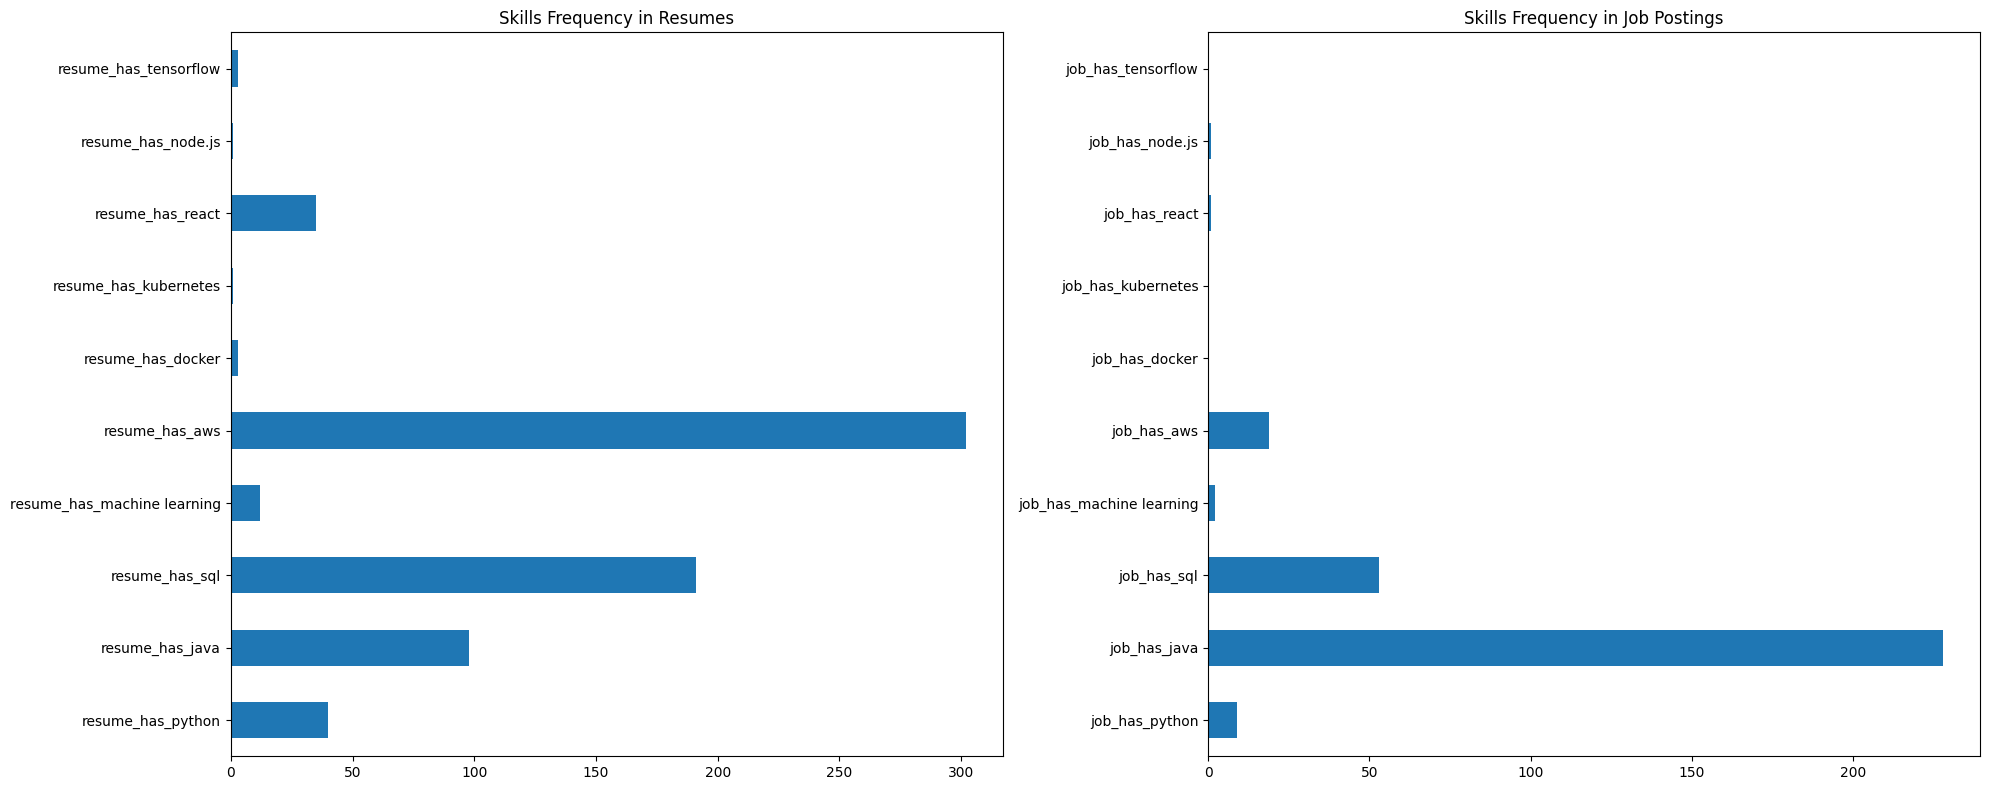

In [6]:
# Common skills extraction (simplified)
# Add/update list with keywords we are interested in
skills_keywords = ['python', 'java', 'sql', 'machine learning', 'aws',
                   'docker', 'kubernetes', 'react', 'node.js', 'tensorflow']

def count_skills(text, skills_list):
    text_lower = text.lower()
    return sum(1 for skill in skills_list if skill in text_lower)

# Count skills in resumes and job postings
for skill in skills_keywords:
    resume_df[f'resume_has_{skill}'] = resume_df['Resume_str'].str.lower().str.contains(skill)
    job_posts_df[f'job_has_{skill}'] = job_posts_df['JobDescription'].str.lower().str.contains(skill)

# Plot skills frequency
resume_skills_count = resume_df[[f'resume_has_{skill}' for skill in skills_keywords]].sum()
job_skills_count = job_posts_df[[f'job_has_{skill}' for skill in skills_keywords]].sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
resume_skills_count.plot(kind='barh', ax=ax1)
ax1.set_title('Skills Frequency in Resumes')
job_skills_count.plot(kind='barh', ax=ax2)
ax2.set_title('Skills Frequency in Job Postings')
plt.tight_layout()
plt.show()

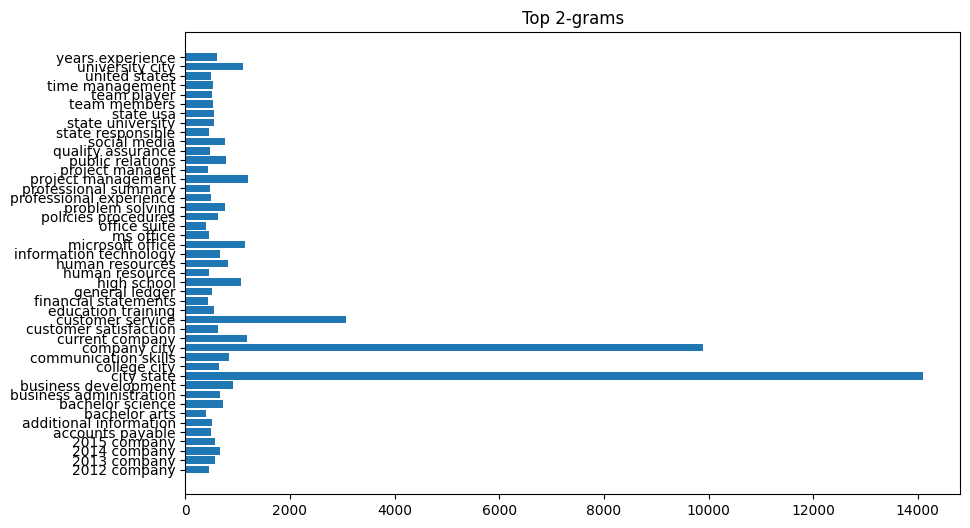

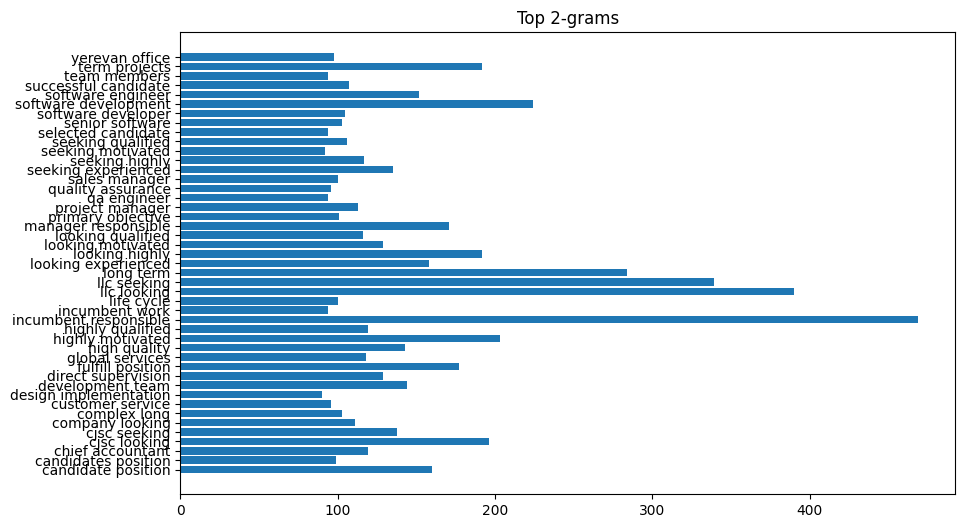

In [7]:
# Bigram analysis
def plot_top_ngrams(text_series, n=2, top_k=45):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english',
                               max_features=top_k)
    X = vectorizer.fit_transform(text_series)
    words = vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1

    plt.figure(figsize=(10, 6))
    plt.barh(words, counts)
    plt.title(f'Top {n}-grams')
    plt.show()

# Compare bigrams in resumes vs job postings
plot_top_ngrams(resume_df['Resume_str'], n=2)
plot_top_ngrams(job_posts_df['JobDescription'], n=2)

In [9]:
def count_keywords_in_series(text_series, domain_keywords_dict):
    """Counts all domain keywords in a pandas Series of text efficiently."""
    domain_counts = {domain: 0 for domain in domain_keywords_dict}
    keyword_counts = Counter()
    
    for domain, keywords in domain_keywords_dict.items():
        for kw in keywords:
            # Build a regex for full word or phrase match (case-insensitive)
            pattern = rf'\b{re.escape(kw.lower())}\b'
            # Sum counts across all rows
            count = text_series.str.count(pattern, flags=re.IGNORECASE).sum()
            if count > 0:
                domain_counts[domain] += count
                keyword_counts[(domain, kw)] += count
                
    return domain_counts, keyword_counts

# Use DOMAIN_KEYWORDS_REFERENCE from utils
resume_domain_counts, resume_kw_counts = count_keywords_in_series(
    resume_df['Resume_str'], 
    DOMAIN_KEYWORDS_REFERENCE
)
job_domain_counts, job_kw_counts = count_keywords_in_series(
    job_posts_df['job_text'], 
    DOMAIN_KEYWORDS_REFERENCE
)

domain_summary = pd.DataFrame({
    'domain': list(DOMAIN_KEYWORDS_REFERENCE.keys()),
    'resume_keyword_count': [resume_domain_counts[d] for d in DOMAIN_KEYWORDS_REFERENCE],
    'job_keyword_count': [job_domain_counts[d] for d in DOMAIN_KEYWORDS_REFERENCE]
}).sort_values(by='resume_keyword_count', ascending=False)

# Optional: detailed keyword-level breakdown
resume_kw_df = pd.DataFrame(resume_kw_counts.items(), columns=['(domain, keyword)', 'resume_count'])
job_kw_df = pd.DataFrame(job_kw_counts.items(), columns=['(domain, keyword)', 'job_count'])

print("✓ Keyword analysis complete!")
display(domain_summary)

✓ Keyword analysis complete!


,domain,resume_keyword_count,job_keyword_count
5,HR & Operations,9349,3318
1,Finance & Accounting,8721,4681
8,Manufacturing & Construction,6916,2544
4,Healthcare,5964,839
10,Hospitality & Food,5835,515
7,Education,5495,1571
11,Other Services,5086,1392
0,Tech & IT,4159,8588
2,Business & Sales,2373,706
6,Creative & Design,1669,890


In [10]:
# Show top 10 keywords by count
print("=== Resume Keyword Counts (Top 30) ===")
display(resume_kw_df.sort_values('resume_count', ascending=False).head(30))

print("=== Job Keyword Counts (Top 30) ===")
display(job_kw_df.sort_values('job_count', ascending=False).head(30))



=== Resume Keyword Counts (Top 30) ===


,"(domain, keyword)",resume_count
145,"(Education, education)",4093
195,"(Hospitality & Food, customer service)",3004
29,"(Finance & Accounting, accounting)",2839
156,"(Manufacturing & Construction, engineering)",1979
205,"(Other Services, maintenance)",1824
155,"(Manufacturing & Construction, construction)",1810
115,"(HR & Operations, compliance)",1622
28,"(Finance & Accounting, finance)",1579
84,"(Healthcare, medical)",1519
107,"(HR & Operations, payroll)",1485


=== Job Keyword Counts (Top 30) ===


,"(domain, keyword)",job_count
23,"(Finance & Accounting, accounting)",1998
2,"(Tech & IT, software development)",1666
127,"(Education, education)",1553
109,"(HR & Operations, documentation)",1315
7,"(Tech & IT, database)",1216
22,"(Finance & Accounting, finance)",1191
5,"(Tech & IT, sql)",1170
0,"(Tech & IT, programming)",1150
133,"(Manufacturing & Construction, engineering)",1145
4,"(Tech & IT, java)",1094


In [11]:

print("=== Domain-Level Keyword Summary ===")
print(domain_summary, "\n")

print("=== Sample Keyword-Level Breakdown (Top 10) ===")
print(resume_kw_df.sort_values('resume_count', ascending=False))

=== Domain-Level Keyword Summary ===
                          domain  resume_keyword_count  job_keyword_count
5                HR & Operations                  9349               3318
1           Finance & Accounting                  8721               4681
8   Manufacturing & Construction                  6916               2544
4                     Healthcare                  5964                839
10            Hospitality & Food                  5835                515
7                      Education                  5495               1571
11                Other Services                  5086               1392
0                      Tech & IT                  4159               8588
2               Business & Sales                  2373                706
6              Creative & Design                  1669                890
3                 Law & Advocacy                  1237                929
9      Agriculture & Environment                   419                440 


In [12]:
kw_compare = pd.merge(
    resume_kw_df, job_kw_df,
    on='(domain, keyword)', how='outer'
).fillna(0)

kw_compare['difference'] = kw_compare['resume_count'] - kw_compare['job_count']

# Show top 20 overrepresented in resumes
kw_compare.sort_values('difference', ascending=False).head(20)


,"(domain, keyword)",resume_count,job_count,difference
133,"(Hospitality & Food, customer service)",3004.0,344.0,2660.0
55,"(Education, education)",4093.0,1553.0,2540.0
103,"(HR & Operations, payroll)",1485.0,68.0,1417.0
159,"(Manufacturing & Construction, construction)",1810.0,613.0,1197.0
116,"(Healthcare, medical)",1519.0,419.0,1100.0
182,"(Other Services, maintenance)",1824.0,727.0,1097.0
91,"(HR & Operations, compliance)",1622.0,543.0,1079.0
62,"(Education, teacher)",1004.0,8.0,996.0
65,"(Finance & Accounting, accounting)",2839.0,1998.0,841.0
162,"(Manufacturing & Construction, engineering)",1979.0,1145.0,834.0
